# SVGD 
Adapted from [here](https://colab.research.google.com/github/activatedgeek/stein-gradient/blob/master/Stein.ipynb#scrollTo=-c6hPMDLqceL).

Code by the authors of the original paper is avaiable [here](https://github.com/dilinwang820/Stein-Variational-Gradient-Descent).

In [1]:
import math
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import MultivariateNormal
from pymanopt.manifolds import Grassmann
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

alt.data_transformers.enable('default', max_rows=None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Drawing utilities

In [3]:
def get_density_chart(P, d=7.0, step=0.1):
    xv, yv = torch.meshgrid([
      torch.arange(-d, d, step), 
      torch.arange(-d, d, step)
    ])
    pos_xy = torch.cat((xv.unsqueeze(-1), yv.unsqueeze(-1)), dim=-1)
    p_xy = P.log_prob(pos_xy.to(device)).exp().unsqueeze(-1).cpu()

    df = torch.cat([pos_xy, p_xy], dim=-1).numpy()
    df = pd.DataFrame({
      'x': df[:, :, 0].ravel(),
      'y': df[:, :, 1].ravel(),
      'p': df[:, :, 2].ravel(),
    })

    chart = alt.Chart(df).mark_point().encode(
    x='x:Q',
    y='y:Q',
    color=alt.Color('p:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['x','y','p']
    )

    return chart


def get_particles_chart(X):
    df = pd.DataFrame({
      'x': X[:, 0],
      'y': X[:, 1],
    })

    chart = alt.Chart(df).mark_circle(color='red').encode(
    x='x:Q',
    y='y:Q'
    )

    return chart

### RBF kernel

In [4]:
class RBF(torch.nn.Module):
    def __init__(self, sigma=None):
        super(RBF, self).__init__()
        self.sigma = sigma

    def forward(self, X, Y):
        XX = X.matmul(X.t())
        XY = X.matmul(Y.t())
        YY = Y.matmul(Y.t())

        dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

        # median heuristic
        if self.sigma is None:
            np_dnorm2 = dnorm2.detach().cpu().numpy()
            h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
            sigma = np.sqrt(h).item()
        else:
            sigma = self.sigma

        sigma_inv = 1.0 / (1e-8 + 2 * sigma ** 2)
        K_XY = (-sigma_inv * dnorm2).exp()

        return K_XY


### SVGD

In [5]:
class SVGD:
    def __init__(self, particles, kernel, optimizer):
        self.p = particles
        self.k = kernel
        self.optim = optimizer

    def phi(self, X):
        X = X.detach().requires_grad_(True)

        log_prob = self.p.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]

        K_XX = self.k(X, X.detach())
        grad_K = -autograd.grad(K_XX.sum(), X)[0]

        phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)
        return phi

    def step(self, X):
        self.optim.zero_grad()
        X.grad = -self.phi(X)
        self.optim.step()
        
    def fit(self, x0, epochs):
        for _ in range(epochs):
            self.step(x0)

## Mixture of Gaussians (1D)

In [6]:
K = RBF()

In [58]:
mean = torch.Tensor([[-2.], [2.]]).to(device)
covariance = torch.Tensor([1.]).repeat(2, 1, 1).to(device)
prob = torch.Tensor([[1/3], [2/3]])

gaussian_mix = GaussianMixture(mean=mean, covariance_matrix=covariance, prob=prob)

In [76]:
n = 5000
q_mean = -10 
q_var = 1

# sample from variational density
x_init = q_mean + q_var * torch.randn(n, *gaussian_mix.event_shape)

In [77]:
x = x_init.clone()
lr = 1e-1
epochs = 1000

svgd = SVGD(gaussian_mix, K, optim.Adam([x], lr=lr))
for _ in range(epochs):
    svgd.step(x)

(array([  1.,   0.,  10.,   2.,  40.,  21.,  62., 105., 184., 248., 294.,
        315., 368., 358., 352., 316., 270., 262., 270., 289., 301., 283.,
        251., 183., 114.,  60.,  25.,  10.,   4.,   2.]),
 array([-8.338835  , -7.8498297 , -7.3608246 , -6.871819  , -6.382814  ,
        -5.893809  , -5.4048038 , -4.915798  , -4.426793  , -3.937788  ,
        -3.4487827 , -2.9597776 , -2.4707723 , -1.9817672 , -1.492762  ,
        -1.0037568 , -0.51475155, -0.02574636,  0.46325883,  0.952264  ,
         1.4412693 ,  1.9302745 ,  2.4192796 ,  2.908285  ,  3.39729   ,
         3.8862953 ,  4.3753004 ,  4.8643055 ,  5.353311  ,  5.842316  ,
         6.3313212 ], dtype=float32),
 <BarContainer object of 30 artists>)

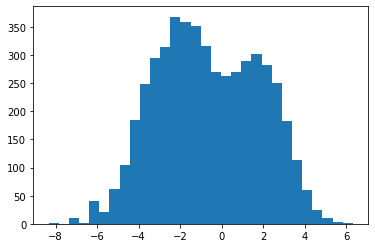

In [78]:
plt.hist(x.cpu().numpy(), bins=30)

## Mixture of Gaussians (2D)

In [7]:
kernel = RBF()

In [48]:
gauss = torch.distributions.MultivariateNormal(
    loc = torch.Tensor([-0.6871,0.8010]),
    covariance_matrix = 5 * torch.Tensor([[0.2260,0.1652],[0.1652,0.6779]]).to(device)
)

n = 100
x_init = (3 * torch.randn(n, *gauss.event_shape)).to(device)

In [36]:
gauss_chart = get_density_chart(gauss, d=7.0, step=0.1)
gauss_chart + get_particles_chart(x_init.cpu().numpy())

alt.LayerChart(...)

In [37]:
x = x_init.clone()
svgd = SVGD(gauss, kernel, optim.Adam([x], lr=1e-1))
svgd.fit(x, 1000)

In [38]:
gauss_chart + get_particles_chart(x.cpu().numpy())

alt.LayerChart(...)

In [66]:
x_final = x.cpu().numpy().copy()
x_true = gauss.sample((5000,))

[(-5.0, 6.0), (-5.0, 3.0), Text(0.5, 1.0, 'True density')]

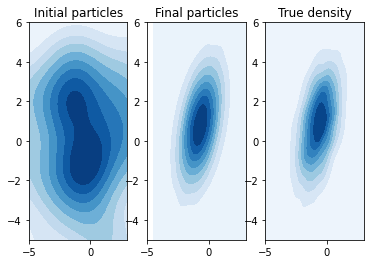

In [73]:
ylims = [-5, 6]
xlims = [-5, 3]

plt.subplot(1, 3, 1)
g1 = sns.kdeplot(x=x_init[:, 0], y=x_init[:, 1], cmap="Blues", shade=True, thresh=0)
g1.set(ylim=ylims, xlim=xlims, title="Initial particles")

plt.subplot(1, 3, 2)
g2 = sns.kdeplot(x=x_final[:, 0], y=x_final[:, 1], cmap="Blues", shade=True, thresh=0)
g2.set(ylim=ylims, xlim=xlims, title="Final particles")

plt.subplot(1, 3, 3)
g3 = sns.kdeplot(x=x_true[:, 0], y=x_true[:, 1], cmap="Blues", shade=True, thresh=0)
g3.set(ylim=ylims, xlim=xlims, title="True density")

In [12]:
class GaussianMixture(torch.distributions.Distribution):
    def __init__(self, mean: np.array, covariance_matrix: np.array, prob: np.array) -> None:
        self.num_components = mean.size(0)
        self.mu = mean
        self.covariance_matrix = covariance_matrix
        self.prob = prob

        self.dists = [
          torch.distributions.MultivariateNormal(mu, covariance_matrix=sigma)
          for mu, sigma in zip(mean, covariance_matrix)
        ]

        super(GaussianMixture, self).__init__(torch.Size([]), torch.Size([mean.size(-1)]))

    def log_prob(self, value):
        return torch.cat(
            [p * d.log_prob(value).unsqueeze(-1) for p, d in zip(self.prob, self.dists)], 
            dim=-1).logsumexp(dim=-1)

    def enumerate_support(self):
        return self.dists[0].enumerate_support()

In [13]:
mean = torch.Tensor([[-2., 0.], [2., 0.]]).to(device)
covariance = torch.Tensor([[1., 0.], [0., 1.]]).repeat(2, 1, 1).to(device)
prob = torch.Tensor([[1/3], [2/3]])

gaussian_mix = GaussianMixture(mean=mean, covariance_matrix=covariance, prob=prob)

In [14]:
n = 100
q_mean = -10 
q_var = 1

# sample from variational density
x_init = q_mean + q_var * torch.randn(n, *gaussian_mix.event_shape)

In [15]:
x = x_init.clone()
lr = 1e-1
epochs = 1000

svgd = SVGD(gaussian_mix, K, optim.Adam([x], lr=lr))
for _ in range(epochs):
    svgd.step(x)

In [16]:
fig = get_density_chart(gaussian_mix, d=7.0, step=0.1)

(fig + get_particles_chart(x_init.cpu().numpy())) | (fig + get_particles_chart(x.cpu().numpy()))

alt.HConcatChart(...)

# Grassman SVGD

In [6]:
class GSVGD:
    def __init__(self, target, kernel, optimizer):
        self.target = target
        self.k = kernel
        self.optim = optimizer
        
    def phi(self, X, P0):
        X = X.detach().requires_grad_(True)
        
        log_prob = self.target.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]

        K_XX = self.k(X, X.detach())
        grad_K = -autograd.grad(K_XX.sum(), X)[0]

        #! need to change this line to add ortho projecion P!
        phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0) 
        return phi

    def step(self, X):
        self.optim.zero_grad()
        X.grad = -self.phi(X)
        #! need to update P here!
        self.optim.step()
        
    def fit(self, x0, epochs):
        for _ in range(epochs):
            self.step(x0)

In [7]:
kernel = RBF()

In [8]:
gauss = torch.distributions.MultivariateNormal(
    loc = torch.Tensor([-0.6871,0.8010]),
    covariance_matrix = 5 * torch.Tensor([[0.2260,0.1652],[0.1652,0.6779]]).to(device)
)

n = 100
x_init = (3 * torch.randn(n, *gauss.event_shape)).to(device)

In [9]:
x = x_init.clone()
svgd = SVGD(gauss, kernel, optim.Adam([x], lr=1e-1))
svgd.fit(x, 1000)

In [10]:
x_final = x.cpu().numpy().copy()
x_true = gauss.sample((5000,))

[(-5.0, 6.0), (-5.0, 3.0), Text(0.5, 1.0, 'True density')]

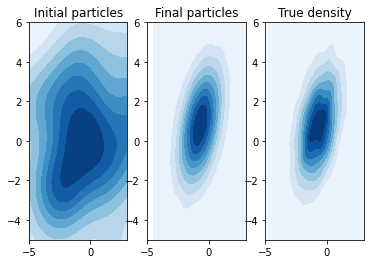

In [11]:
ylims = [-5, 6]
xlims = [-5, 3]

plt.subplot(1, 3, 1)
g1 = sns.kdeplot(x=x_init[:, 0], y=x_init[:, 1], cmap="Blues", shade=True, thresh=0)
g1.set(ylim=ylims, xlim=xlims, title="Initial particles")

plt.subplot(1, 3, 2)
g2 = sns.kdeplot(x=x_final[:, 0], y=x_final[:, 1], cmap="Blues", shade=True, thresh=0)
g2.set(ylim=ylims, xlim=xlims, title="Final particles")

plt.subplot(1, 3, 3)
g3 = sns.kdeplot(x=x_true[:, 0], y=x_true[:, 1], cmap="Blues", shade=True, thresh=0)
g3.set(ylim=ylims, xlim=xlims, title="True density")

In [12]:
manifold = Grassmann(2, 1)


In [36]:
X = torch.Tensor([[1, 0], [0, 1]])
U = torch.Tensor([[1, 0], [0, 1]])

X = torch.Tensor([[1], [0]])
U = torch.Tensor([[0], [1]])

# xx = manifold.rand() 
# xx @ manifold.randvec()
manifold.egrad2rgrad(X, U)

tensor([[0.],
        [1.]])

In [39]:
manifold.randvec(X)

array([[1.],
       [0.]])